# Ablation study

**Objetivo:** Comparar los resultados obtenidos en los distintos pasos vs un enfoque baseline


# Dependencies

In [1]:
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from dowhy import CausalModel
from castle.common import GraphDAG
from castle.algorithms import PC
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.search.ScoreBased.GES import ges

from config import TREATMENT, OUTCOME, SEED
from utils.graphs import (
    get_nx_graph_FCI,
    create_prior,
    get_edges_list_from_gcastlegraph,
    analyze_dag_issues,
    make_dag,
    get_outcome_only_causes,
    get_nx_graph_ges,
    redirect_edges_by_domain_knownledge,
)


from utils.preprocessing import create_stratification_split_col

warnings.filterwarnings("ignore")

2025-02-10 10:54:00,261 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\castle\backend\__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2025-02-10 10:54:00,339 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\castle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


# Environment variables

In [2]:
CONTROLS_PATH = "data/controls.txt"
OUTCOME_CAUSES_PATH = "data/outcome_causes.txt"
DATA_GENERATOR_PATH = 'data/data_generator.pkl'

In [3]:
np.random.seed(SEED)

# Utils

# Data

In [4]:
df_original = pd.read_parquet("data/synthetic_data.parquet")

In [5]:
with open(DATA_GENERATOR_PATH, 'rb') as file:
    generator = pickle.load(file)

In [6]:
gournd_truth_confounders = generator.confounders
gournd_truth_outcome_causes = generator.outcome_only

# Split

In [7]:
strat_feature = create_stratification_split_col(df_original, TREATMENT, OUTCOME)
train, test = train_test_split(
    df_original, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=strat_feature,
)


X_train, y_train = (
    train.drop(columns=[OUTCOME]).copy(),
    train[[OUTCOME]],
)
X_test, y_test = (
    test[X_train.columns],
    test[[OUTCOME]],
)
test_original = df_original.loc[test.index, :]
print(X_train.shape, X_test.shape)

(12000, 411) (3000, 411)


In [8]:
# Scale
features_scale = list(X_train.columns)
train_scaled = train.copy()
test_scaled = test.copy()

scaler = StandardScaler()
train_scaled[features_scale] = pd.DataFrame(
    scaler.fit_transform(train[features_scale]), columns=features_scale, index=train.index
)
test_scaled[features_scale] = pd.DataFrame(
    scaler.transform(test[features_scale]), columns=features_scale, index=test.index
)

# Identification without dimensionality reduction

In [9]:
features_graph = list(X_train.columns) + [OUTCOME]

## PC

[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


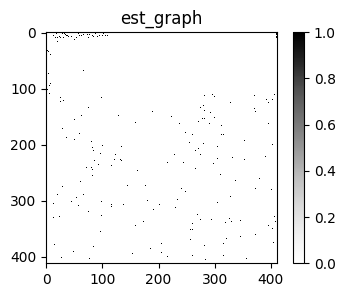

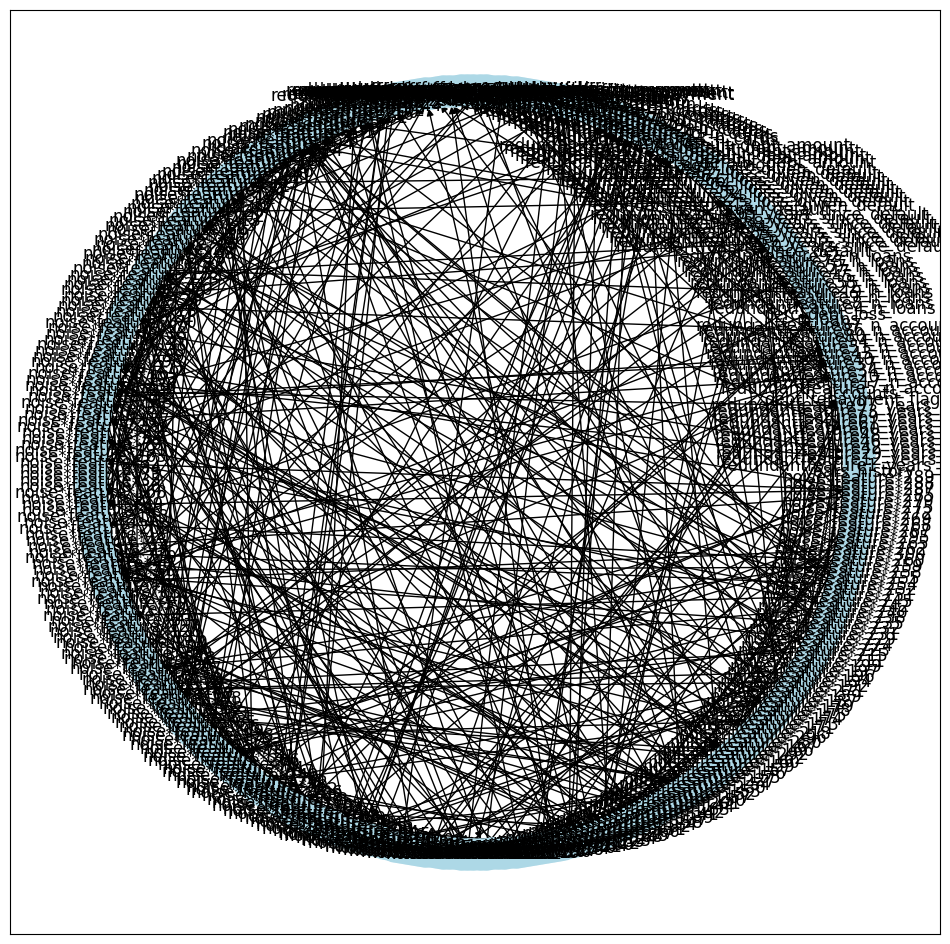

In [10]:
# gcastle
priori = create_prior(
    train[features_graph],
    "gcastle",
    TREATMENT,
    OUTCOME,
    "pc",
    force_treatmemnt_output=True,
)

pc_gcstle = PC(variant="original", alpha=0.01, ci_test="fisherz", priori_knowledge=priori)
pc_gcstle.learn(train_scaled[features_graph])

print(pc_gcstle.causal_matrix)

# plot predict_dag and true_dag
GraphDAG(pc_gcstle.causal_matrix)

# add edges from a list of tuples
edges_list = get_edges_list_from_gcastlegraph(pc_gcstle, features_graph)

# create a directed graph
pc_G = nx.DiGraph()
pc_G.add_edges_from(edges_list)

# draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    pc_G,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    pos=nx.circular_layout(pc_G),
)
plt.show()

In [11]:
# First analyze the issues
problematic_edges = analyze_dag_issues(pc_G)

# If you want to automatically fix it
if len(problematic_edges) > 0:
    pc_G = make_dag(pc_G)

Found cycles:
noise*feature*176 -> noise*feature*155 -> noise*feature*176
noise*feature*158 -> noise*feature*134 -> noise*feature*158
noise*feature*124 -> noise*feature*188 -> noise*feature*124
redundantfeature98_debt_cirbe -> debt_cirbe -> redundantfeature98_debt_cirbe
redundantfeature25_debt_cirbe -> debt_cirbe -> redundantfeature25_debt_cirbe
debt_cirbe -> redundantfeature16_debt_cirbe -> debt_cirbe
months_since_first_payment -> redundantfeature7_months_since_first_payment -> months_since_first_payment
months_since_first_payment -> redundantfeature30_months_since_first_payment -> months_since_first_payment
months_since_first_payment -> redundantfeature63_months_since_first_payment -> months_since_first_payment
months_since_first_payment -> redundantfeature79_months_since_first_payment -> months_since_first_payment
months_since_first_payment -> redundantfeature81_months_since_first_payment -> months_since_first_payment
redundantfeature89_n_refin -> n_refin -> redundantfeature89_n_ref

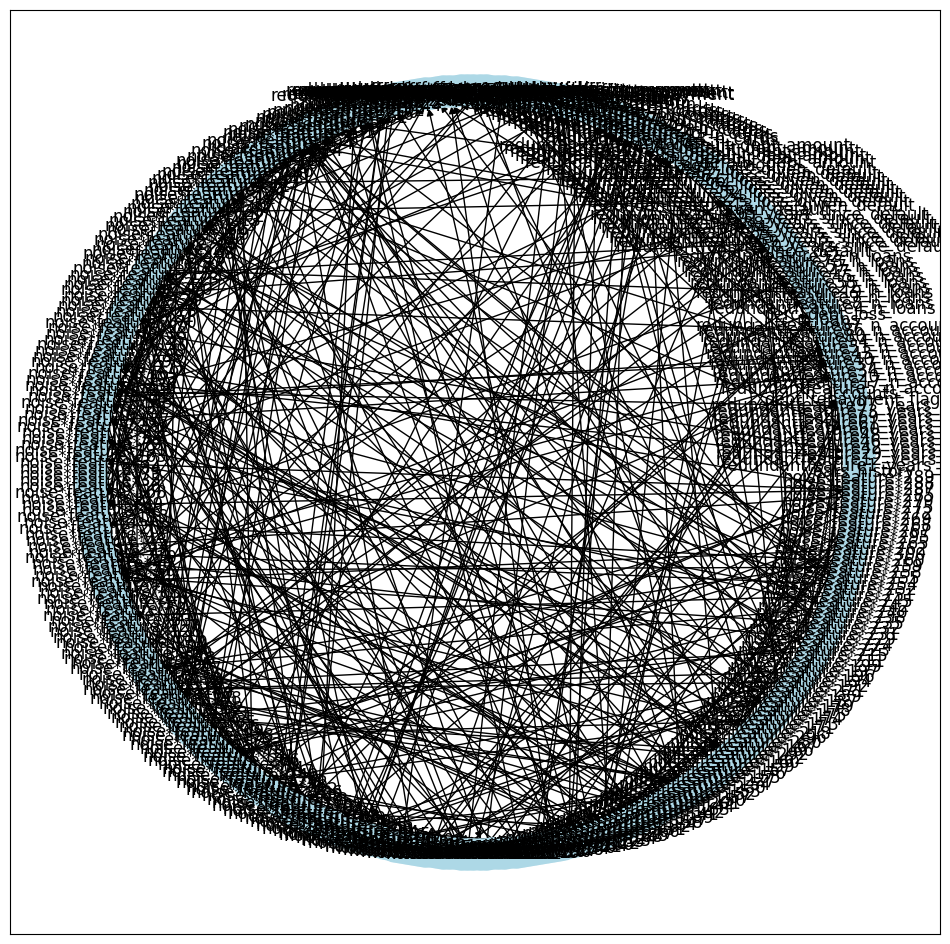

In [12]:
edges_list = [e for e in pc_G.edges]
if (TREATMENT, OUTCOME) not in edges_list:
    pc_G.add_edge(TREATMENT, OUTCOME)
    
# draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    pc_G,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    pos=nx.circular_layout(pc_G),
)
plt.show()

In [13]:
model_pc = CausalModel(
    data=train[features_graph],
    treatment=TREATMENT,
    outcome=OUTCOME,
    graph="\n".join(nx.generate_gml(pc_G)),
)

# Identify the effect
identified_estimand_pc = model_pc.identify_effect()

print(identified_estimand_pc)

2025-02-10 11:23:26,898 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:505] - INFO: Model to find the causal effect of treatment ['perc_debt_loss'] on outcome ['debt_repayment_flag']
2025-02-10 11:23:26,899 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:613] - WARNING: There are an additional 13 variables in the dataset that are not in the graph. Variable names are: '['noise*feature*104', 'noise*feature*105', 'noise*feature*129', 'noise*feature*140', 'noise*feature*17', 'noise*feature*225', 'noise*feature*237', 'noise*feature*248', 'noise*feature*249', 'noise*feature*256', 'noise*feature*273', 'noise*feature*274', 'noise*feature*277']'
2025-02-10 11:51:46,398 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_identifier\auto_identifier.py[line:719] - WARNING: Max number of iterations 100000 reached. Could not find a valid backdoor set.
2025-02-10 11:51:46,400 - c:\

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
─────────────────(E[debt_repayment_flag|redundantfeature37_n_accounts,noise*fe
d[perc_debt_loss]                                                             

                                                                              
ature*210,noise*feature*200,noise*feature*258,redundantfeature74_months_since_
                                                                              

                                                                              
first_payment,redundantfeature78_n_loans,noise*feature*299,redundantfeature6_d
                                                                              

                                                                              
ebt_cirbe,redundantfeature68_default_debt_amount,redundantfeature24_loss_given
                   

In [14]:
estimate = model_pc.estimate_effect(
    identified_estimand_pc,
    method_name="backdoor.linear_regression",
    test_significance=True,
)
print(estimate)

2025-02-10 11:51:46,666 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:329] - INFO: linear_regression
2025-02-10 11:51:46,667 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_estimators\linear_regression_estimator.py[line:70] - INFO: INFO: Using Linear Regression Estimator
2025-02-10 11:51:46,677 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_estimators\regression_estimator.py[line:147] - INFO: b: debt_repayment_flag~perc_debt_loss+redundantfeature37_n_accounts+noise*feature*210+noise*feature*200+noise*feature*258+redundantfeature74_months_since_first_payment+redundantfeature78_n_loans+noise*feature*299+redundantfeature6_debt_cirbe+redundantfeature68_default_debt_amount+redundantfeature24_loss_given_default+redundantfeature53_n_cards+redundantfeature87_n_accounts+noise*feature*148+n_loans+months_since_first_payment+noise*feature*33+redundantfeature93_loss_given_default+redunda

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
─────────────────(E[debt_repayment_flag|redundantfeature37_n_accounts,noise*fe
d[perc_debt_loss]                                                             

                                                                              
ature*210,noise*feature*200,noise*feature*258,redundantfeature74_months_since_
                                                                              

                                                                              
first_payment,redundantfeature78_n_loans,noise*feature*299,redundantfeature6_d
                                                                              

                                                                              
ebt_cirbe,redundantfeature68_default_debt_amount,r

In [15]:
backdoor_variables_pc = identified_estimand_pc.get_backdoor_variables()
print("Backdoor adjustment set PC:", backdoor_variables_pc)

Backdoor adjustment set PC: ['redundantfeature37_n_accounts', 'noise*feature*210', 'noise*feature*200', 'noise*feature*258', 'redundantfeature74_months_since_first_payment', 'redundantfeature78_n_loans', 'noise*feature*299', 'redundantfeature6_debt_cirbe', 'redundantfeature68_default_debt_amount', 'redundantfeature24_loss_given_default', 'redundantfeature53_n_cards', 'redundantfeature87_n_accounts', 'noise*feature*148', 'n_loans', 'months_since_first_payment', 'noise*feature*33', 'redundantfeature93_loss_given_default', 'redundantfeature10_debt_cirbe', 'noise*feature*239', 'redundantfeature60_years_history', 'redundantfeature69_years_history', 'noise*feature*207', 'redundantfeature50_years_since_default', 'noise*feature*183', 'noise*feature*81', 'redundantfeature48_years_history', 'redundantfeature71_default_debt_amount', 'redundantfeature82_loss_given_default', 'redundantfeature100_debt_cirbe', 'noise*feature*39', 'redundantfeature67_loss_given_default', 'redundantfeature32_debt_cirbe

In [16]:
outcome_causes_pc = get_outcome_only_causes(pc_G, OUTCOME, TREATMENT)

Features that cause ONLY the outcome: ['years_history', 'n_accounts', 'months_since_first_payment', 'noise*feature*164', 'noise*feature*266']


In [17]:
len(backdoor_variables_pc) + len(outcome_causes_pc)

In [18]:
accurate_confounders_PC = [c for c in backdoor_variables_pc if c in gournd_truth_confounders]
accurate_outocme_causes_PC = [c for c in outcome_causes_pc if c in gournd_truth_outcome_causes]
print("PC accurate confounders:", accurate_confounders_PC)
print("PC accurate outcome causes:", accurate_outocme_causes_PC)

PC accurate confounders: ['n_loans', 'default_debt_amount', 'n_cards', 'debt_cirbe', 'years_since_default']
PC accurate outcome causes: ['years_history', 'n_accounts', 'months_since_first_payment']


In [19]:
failed_confounders_PC = [c for c in backdoor_variables_pc if c not in gournd_truth_confounders]
failed_outocme_causes_PC = [c for c in outcome_causes_pc if c not in gournd_truth_outcome_causes]
print("PC failed confounders:", len(failed_confounders_PC))
print("PC failed outcome causes:", len(failed_outocme_causes_PC))

PC failed confounders: 159
PC failed outcome causes: 2


## FCI

  0%|          | 0/412 [00:00<?, ?it/s]

Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X412
Orienting edge (Knowledge): X2 --> X412
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X3 --> X412
Orienting edge (Knowledge): X4 --> X11
Orienting edge (Knowledge): X4 --> X412
Orienting edge (Knowledge): X5 --> X11
Orienting edge (Knowledge): X5 --> X412
Orienting edge (Knowledge): X6 --> X11
Orienting edge (Knowledge): X7 --> X11
Orienting edge (Knowledge): X8 --> X11
Orienting edge (Knowledge): X8 --> X412
Orienting edge (Knowledge): X9 --> X412
Orienting edge (Knowledge): X10 --> X11
Orienting edge (Knowledge): X10 --> X412
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X412
Orienting edge (Knowledge): X2 --> X412
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X3 --> X412
Orienting edge (Knowledge): X4 --> X11
Orienting edge (Knowledge): X4 --> X412
Orienting edge (Knowledge): X5 --> X11
Orienting edge (Knowledge): X5 --> X412
Orienting ed

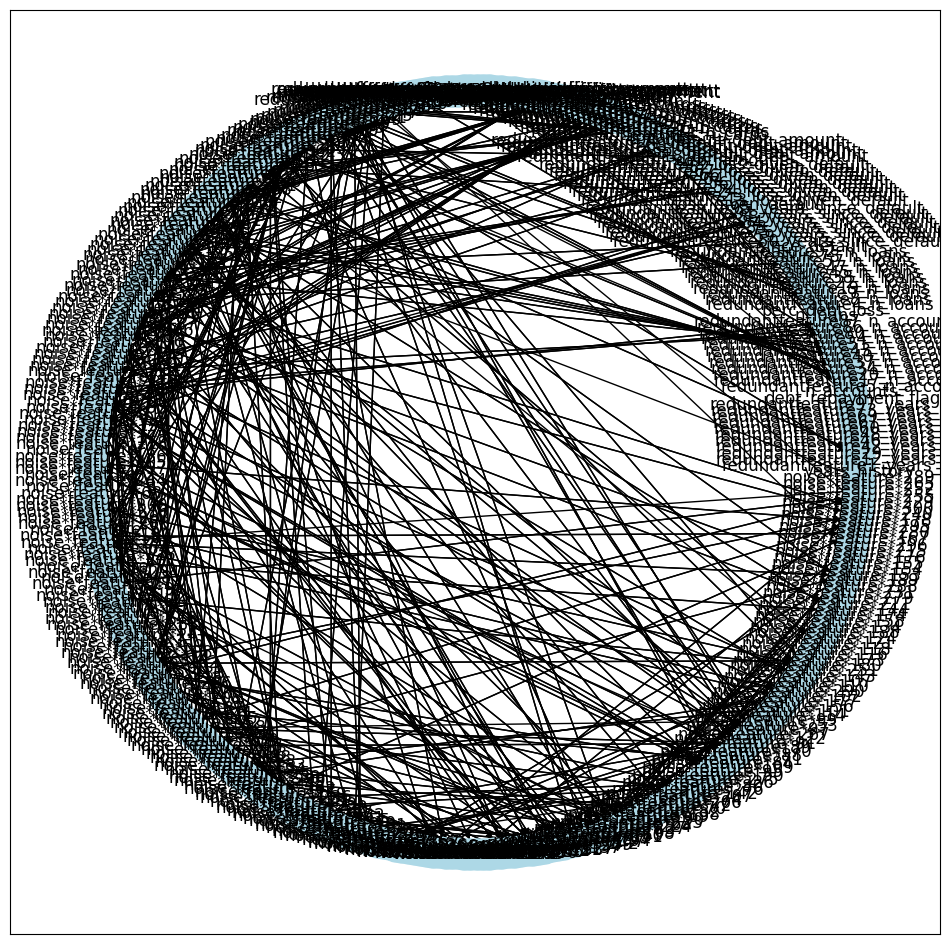

In [20]:
priori = create_prior(
    train_scaled[features_graph],
    "causal-learn",
    TREATMENT,
    OUTCOME,
    "fci",
    force_treatmemnt_output=True,
)

# or customized parameters
graph_fci, edges = fci(
    dataset=train_scaled[features_graph].to_numpy(),
    independence_test_method="fisherz",  # kci
    background_knowledge=priori,
    alpha=0.01,
)

fci_G = get_nx_graph_FCI(graph_fci.graph, features_graph)

# draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    fci_G,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    pos=nx.circular_layout(fci_G),
)
plt.show()

In [ ]:
# First analyze the issues
problematic_edges = analyze_dag_issues(fci_G)
print(len(problematic_edges))

# If you want to automatically fix it
if len(problematic_edges) > 0:
    fci_G = make_dag(fci_G)

In [ ]:
# force connection
edges_list = [e for e in fci_G.edges]
if (TREATMENT, OUTCOME) not in edges_list:
    fci_G.add_edge(TREATMENT, OUTCOME)

# draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    fci_G,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    pos=nx.circular_layout(fci_G),
)
plt.show()

NameError: name 'fci_G' is not defined

In [ ]:
model_fci = CausalModel(
    data=train[features_graph],
    treatment=TREATMENT,
    outcome=OUTCOME,
    graph="\n".join(nx.generate_gml(fci_G)),
)

# Identify the effect
identified_estimand_fci = model_fci.identify_effect()

print(identified_estimand_fci)

2025-01-19 19:38:08,930 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:505] - INFO: Model to find the causal effect of treatment ['perc_debt_forgivness'] on outcome ['debt_repayment_flag']
2025-01-19 19:38:08,930 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:613] - WARNING: There are an additional 33 variables in the dataset that are not in the graph. Variable names are: '['noise*feature*1', 'noise*feature*10', 'noise*feature*14', 'noise*feature*17', 'noise*feature*19', 'noise*feature*22', 'noise*feature*26', 'noise*feature*30', 'noise*feature*33', 'noise*feature*39', 'noise*feature*41', 'noise*feature*42', 'noise*feature*43', 'noise*feature*5', 'noise*feature*50', 'noise*feature*57', 'noise*feature*58', 'noise*feature*62', 'noise*feature*64', 'noise*feature*69', 'noise*feature*72', 'noise*feature*75', 'noise*feature*76', 'noise*feature*78', 'noise*feature*83', 'noise*feature*85', 'noise*feat

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
───────────────────────(E[debt_repayment_flag|redundantfeature13_n_loans,n_ref
d[perc_debt_forgivness]                                                       

                                                                              
in,n_accounts,years_history,years_since_default,redundantfeature2_loss_given_d
                                                                              

                                                                              
efault,default_debt_amount,noise*feature*24,noise*feature*12,noise*feature*52,
                                                                              

                                                                              
redundantfeature10_n_accounts,redundantfeature17_n_accounts,redundantfeature18
                   

In [ ]:
estimate = model_fci.estimate_effect(
    identified_estimand_fci,
    method_name="backdoor.linear_regression",
    test_significance=True,
)
print(estimate)

2025-01-19 19:39:12,806 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:329] - INFO: linear_regression
2025-01-19 19:39:12,809 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_estimators\linear_regression_estimator.py[line:70] - INFO: INFO: Using Linear Regression Estimator
2025-01-19 19:39:12,810 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_estimators\regression_estimator.py[line:147] - INFO: b: debt_repayment_flag~perc_debt_forgivness+redundantfeature13_n_loans+n_refin+n_accounts+years_history+years_since_default+redundantfeature2_loss_given_default+default_debt_amount+noise*feature*24+noise*feature*12+noise*feature*52+redundantfeature10_n_accounts+redundantfeature17_n_accounts+redundantfeature18_n_refin+redundantfeature6_n_accounts+noise*feature*54+months_since_first_payment+noise*feature*98+redundantfeature11_n_accounts+noise*feature*23+redundantfeature20_n_refin+loss_giv

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
───────────────────────(E[debt_repayment_flag|redundantfeature13_n_loans,n_ref
d[perc_debt_forgivness]                                                       

                                                                              
in,n_accounts,years_history,years_since_default,redundantfeature2_loss_given_d
                                                                              

                                                                              
efault,default_debt_amount,noise*feature*24,noise*feature*12,noise*feature*52,
                                                                              

                                                                              
redundantfeature10_n_accounts,redundantfeature17_n

In [ ]:
backdoor_variables_fci = identified_estimand_fci.get_backdoor_variables()
print("Backdoor adjustment set FCI:", backdoor_variables_fci)

Backdoor adjustment set FCI: ['redundantfeature13_n_loans', 'n_refin', 'n_accounts', 'years_history', 'years_since_default', 'redundantfeature2_loss_given_default', 'default_debt_amount', 'noise*feature*24', 'noise*feature*12', 'noise*feature*52', 'redundantfeature10_n_accounts', 'redundantfeature17_n_accounts', 'redundantfeature18_n_refin', 'redundantfeature6_n_accounts', 'noise*feature*54', 'months_since_first_payment', 'noise*feature*98', 'redundantfeature11_n_accounts', 'noise*feature*23', 'redundantfeature20_n_refin', 'loss_given_default', 'redundantfeature4_n_loans', 'redundantfeature7_n_cards', 'redundantfeature8_n_loans', 'n_loans', 'noise*feature*56', 'noise*feature*71', 'noise*feature*13', 'noise*feature*84', 'redundantfeature16_default_debt_amount', 'redundantfeature9_months_since_first_payment', 'redundantfeature5_n_refin', 'redundantfeature15_n_refin', 'redundantfeature19_n_cards', 'n_cards', 'noise*feature*73', 'noise*feature*11', 'redundantfeature1_n_cards', 'redundantfe

In [ ]:
outcome_causes_fci = get_outcome_only_causes(fci_G, OUTCOME, TREATMENT)

Features that cause ONLY the outcome: ['n_accounts', 'years_history', 'noise*feature*56']


## GES

In [ ]:
graph_ges = ges(
    train_scaled[features_graph], 
    score_func="local_score_BIC", 
    maxP=None, 
    parameters={"kfold": 5}
)

ges_G = get_nx_graph_ges(graph_ges, feature_names=features_graph)

# draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    ges_G,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    pos=nx.circular_layout(ges_G),
)
plt.show()


KeyboardInterrupt: 

In [ ]:
# Domain knowledge redirection
ges_G = redirect_edges_by_domain_knownledge(ges_G)

# force connection
edges_list = [e for e in ges_G.edges]
if (TREATMENT, OUTCOME) not in edges_list:
    ges_G.add_edge(TREATMENT, OUTCOME)

# draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    ges_G,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    pos=nx.circular_layout(ges_G),
)
plt.show()

In [ ]:
model_ges = CausalModel(
    data=train[features_graph],
    treatment=TREATMENT,
    outcome=OUTCOME,
    graph="\n".join(nx.generate_gml(ges_G)),
)

# Identify the effect
identified_estimand_ges = model_ges.identify_effect()

print(identified_estimand_ges)

In [ ]:
estimate = model_ges.estimate_effect(
    identified_estimand_ges,
    method_name="backdoor.linear_regression",
    test_significance=True,
)
print(estimate)

In [ ]:
backdoor_variables_ges = identified_estimand_ges.get_backdoor_variables()
print("Backdoor adjustment set GES:", backdoor_variables_ges)

In [ ]:
outcome_causes_ges = get_outcome_only_causes(ges_G, OUTCOME, TREATMENT)